# Data Sets from the Literature

The following data sets were obtained from the literature.

## Solvolysis/ionization of Trityl chlorides

data5.csv

Data for the solvolysis of triphenylmethylchloride were obtained from..

"Stabilities of Trityl-Protected Substrates: The Wide Mechanistic Spectrum of Trityl Ester Hydrolyses." M. Horn, H. Mayr,  *Chem. Eur. J.*, **2010**, *16*, 7469-7477. https://doi.org/10.1002/chem.200902669


Rates of hydrolysis are reported for substituted triyl chlorides in the following conditions.

1. 90% acetonitrile, 10% water
2. 80% acetonitrile, 20% water
3. 60% acetonitrile, 40% water
4. 50% acetonitrile, 50% water

All data recorded at $25^\circ C$

**Note:** 
- No acid or base added.  
- Rate constants are first-order rate of in [TrCl] and reported in  $s^{-1}$.
- in addition to rate data there is a set of $pK_r$ values that are the $-\log$ of the equilibrium constant for ionization, $K_r$.

### Cleaning Data Set

the code below will extract and clean the data from the database for use in  this analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################

df1 = pd.read_csv("data5.csv",
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 

df1.insert(3, "Total_Sigma", np.NaN, allow_duplicates = False)     # Insert a column for the total sigma value

display(df1)

,Sub1,Sub2,Sub3,Total_Sigma,pKr,k_90ACN,k_80ACN,k_60ACN,k_50ACN
Substituent,,,,,,,,,
None,H,H,H,NaN,-6.63,0.000015,0.000059,0.00027,0.000557
Me,p-CH3,H,H,NaN,-5.41,0.000103,0.000359,0.00146,0.003010
Me2,p-CH3,p-CH3,H,NaN,-4.71,0.000323,0.001210,0.00562,0.009590
Me3,p-CH3,p-CH3,p-CH3,NaN,-3.56,0.001300,0.004980,0.01770,0.033300
OMe,p-OCH3,H,H,NaN,-3.40,0.001200,0.004530,0.01500,0.024000
OMe2,p-OCH3,p-OCH3,H,NaN,-1.24,0.040400,0.115000,0.30600,0.441000
OMe3,p-OCH3,p-OCH3,p-OCH3,NaN,0.82,0.680000,1.580000,3.86000,5.560000
DMA,p-N(CH3)2,H,H,NaN,3.88,1.080000,2.000000,4.51000,7.400000
DMA2,p-N(CH3)2,p-OCH3,H,NaN,4.86,6.230000,12.200000,24.90000,39.300000


## Hammett Parameters from A. Williams
This table presents the Hammett $\sigma$ LFER values collected values presented in the collection curated by A. Williams in his book, “Free Energy Relationships in Organic and Bio-organic Chemistry”, *The Royal Society of Chemistry, Cambridge*, **2003**, pp 258-277. https://doi.org/10.1039/9781847550927.

 The data series are as follows:
 
- **Substituent**
     - The code of the substituent and the **index series**. Hopefully we will use a unique code for each substituent that will apply across all these data tables. Students should use data cleaning methods to track down duplicate data and mismatched codes.
- **sigma**
    - The Hammett $\sigma$ value
- **s_plus**
    - The Brown-Okamoto $\sigma_p^+$ value
- **s_minus**
    - The Brown-Okamoto $\sigma_p^-$ value
- **Page**
    - The page number in book. This is included to enable faster checking of the data by other students (all errors are intentional - to see if they are paying attention.)
    
**Note:** You may also use the Hansch data set available from the GitHub page.

### Cleaning Data Set

the code below will extract and clean the data from the database for use in  this analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


#################################################################
### a function to fill in sigma for empty spaces in s+ and s- ###
#################################################################

def fill_sigma(df):     
    for z in df.index:
        if np.isnan(df.loc[z,"s_plus"]):
            df.loc[z,"s_plus"] = df.loc[z,"sigma"]
        if np.isnan(df["s_minus"][z]):
            df.loc[z,"s_minus"] = df.loc[z,"sigma"]
    return(df)

################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################

#df2 = pd.read_csv("LFER_HanschLeoTaft.csv", 
df2 = pd.read_csv("LFER_Williams.csv",
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 
#display(df2)

########################################################
### Fill across sigma values and select substituents ###
########################################################

df2=fill_sigma(df2)
#display(df2)

###############################
### Remove unneeded columns ###
###############################
 
#df2.drop(labels = ["TABLE V", "TABLE I"],    #Trim "LFER_HanschLeoTaft.csv" data
df2.drop(labels = ["Page"], axis = 1, inplace = True) #Trim "LFER_Williams.csv"" data
 
#df2.sort_values(by=['sigma'], inplace=True)
#display(df2)

## Calculate Total $\sigma$ Values

There are three potential substituents in each molecule in the series. Hammett substituent constants are generally additive (within reason) so we can sum the three $\sigma$ values to create a $\sum\sigma$ value that represent the combined electronic effect of the substituents in diphenylmethylenechloride.

The code below accesses the value of $\sigma$ for each substituent and sums them up to a toyal.  This total is then entered into the dataframe. If one or more of the substituents have no asigned $\sigma$ value (e.g. *ortho*-substituents) then the total is recorded as 'NaN'

In [6]:
####################################################################
### Function to total the sigma values of multiple substituents  ###
####################################################################

def Total_sigma(row, sigmatype, df1, df2):     # inputs the index ("row") and the dataframes for rates (df1) 
                                               # and for sigma values (df2. 
                                               # sigmatype can be one of ["sigma", "s_plus", "s_minus"]
    total = 0.
    for sub in ["Sub1","Sub2","Sub3"]:   # Change this list to match the columns in the data set
        a = (df1[sub][row])

        if a in df2.index:               # If the index does not have a Hammett sigma value return 'NaN'
            sigma = df2[sigmatype][a]
            total = total + float(sigma)
        else:
            total = np.NaN

    return(total)

######################################################################
### calculate combined sigma value for all molecules in dataframe  ###
######################################################################

sigmatype = "sigma"          # sigmatype can be one of ["sigma", "s_plus", "s_minus"]

for molecule in df1.index:

    total = Total_sigma(molecule,sigmatype,df1,df2)
    df1.loc[molecule,"Total_Sigma"] = total

display(df1)

,Sub1,Sub2,Sub3,Total_Sigma,pKr,k_90ACN,k_80ACN,k_60ACN,k_50ACN,log_k_90ACN,log_k_80ACN,log_k_60ACN,log_k_50ACN
Substituent,,,,,,,,,,,,,
None,H,H,H,0.00,-6.63,0.000015,0.000059,0.00027,0.000557,-4.832683,-4.230623,-3.568636,-3.254145
Me,p-CH3,H,H,-0.14,-5.41,0.000103,0.000359,0.00146,0.003010,-3.987163,-3.444906,-2.835647,-2.521434
Me2,p-CH3,p-CH3,H,-0.28,-4.71,0.000323,0.001210,0.00562,0.009590,-3.490797,-2.917215,-2.250264,-2.018181
Me3,p-CH3,p-CH3,p-CH3,-0.42,-3.56,0.001300,0.004980,0.01770,0.033300,-2.886057,-2.302771,-1.752027,-1.477556
OMe,p-OCH3,H,H,-0.27,-3.40,0.001200,0.004530,0.01500,0.024000,-2.920819,-2.343902,-1.823909,-1.619789
OMe2,p-OCH3,p-OCH3,H,-0.54,-1.24,0.040400,0.115000,0.30600,0.441000,-1.393619,-0.939302,-0.514279,-0.355561
OMe3,p-OCH3,p-OCH3,p-OCH3,-0.81,0.82,0.680000,1.580000,3.86000,5.560000,-0.167491,0.198657,0.586587,0.745075
DMA,p-N(CH3)2,H,H,-0.83,3.88,1.080000,2.000000,4.51000,7.400000,0.033424,0.301030,0.654177,0.869232
DMA2,p-N(CH3)2,p-OCH3,H,-1.10,4.86,6.230000,12.200000,24.90000,39.300000,0.794488,1.086360,1.396199,1.594393


## Calculations

The rates are reported in units of $s^{-1}$.  The log values will be calculated for the log-log Hammett plots.

See the code below.

In [7]:
df1["log_k_90ACN"] = np.log10(df1["k_90ACN"])
df1["log_k_80ACN"] = np.log10(df1["k_80ACN"])
df1["log_k_60ACN"] = np.log10(df1["k_60ACN"])
df1["log_k_50ACN"] = np.log10(df1["k_50ACN"])

#display(df1)


## Plot Results

Set up the plot and layer on the x,y results of each experiment.  Use the 'True' and 'False' flags to activate or ignore plot components. Rows with empty data are deleted in each x,y data set before calculating the line fits.

EtOH
slope = -4.414 +/- 0.384
intercept = -4.345 +/- 0.296
rsq = 0.943
p = 2.99e-06

iPrOH
slope = -4.145 +/- 0.358
intercept = -3.734 +/- 0.276
rsq = 0.944
p = 2.8e-06

MeOH
slope = -4.704 +/- 0.280
intercept = -3.418 +/- 0.167
rsq = 0.976
p = 6.55e-07

MeOH
slope = -4.590 +/- 0.247
intercept = -3.132 +/- 0.147
rsq = 0.98
p = 3.24e-07



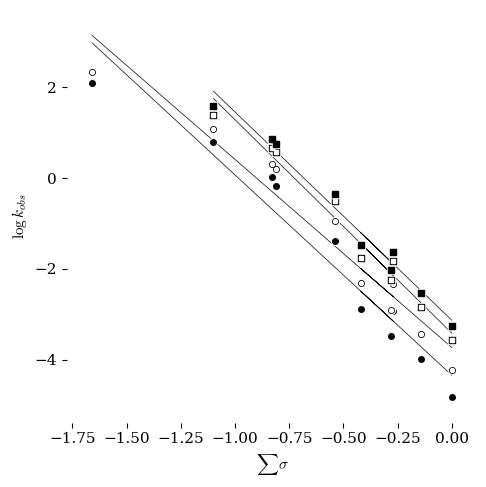

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress

##################################################
### Function to report values from a line fit  ###
##################################################

def Report(comment, result):
    print(comment)
    print(f"slope = {result.slope:-.3f} +/- {result.stderr:.3f}")
    print(f"intercept = {result.intercept:-.3f} +/- {result.intercept_stderr:.3f}")
    print(f"rsq = {(result.rvalue)**2:-.3}")
    print(f"p = {(result.pvalue):-.3}")
    print("")
    
###################################
### Set up plot style and size  ###
###################################

plt.style.use("tufte.mplstyle")        
#plt.style.use("S2_classic2.mplstyle")        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))  
ax.margins(x=.07, y=.07, tight=True)

####################################
### Set up plot axes and labels  ###
####################################

ax.set(
#    title="Initial Rate Log-Log Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$\sum\sigma$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
         )

######################################################################
### In the following blocks of code, each plot is made and placed  ###
### in the plot. Change from 'False' to 'True' to activate a block ###
## of code and place that given plot.                              ###
######################################################################

##############################
if True:
    series = "log_k_90ACN"

    df3 = df1[["Total_Sigma", series]].copy()
    df3.dropna(axis=0, inplace=True)
#    display(df3)
    
    x = df3["Total_Sigma"]
    y = df3[series]
    
    linfit = linregress(x,y)
    fity = linfit.slope * x + linfit.intercept
    ax.plot(x, fity, color='black', zorder=1, linewidth=0.5)
    ax.scatter(x,y, s=32, color="white", marker='o', zorder=3)
    ax.scatter(x,y, s=16, color="black", marker='o', zorder=3)
    
    Report("EtOH", linfit)

##############################
if True:
    series = "log_k_80ACN"

    df3 = df1[["Total_Sigma", series]].copy()
    df3.dropna(axis=0, inplace=True)
#    display(df3)

    x = df3["Total_Sigma"]
    y = df3[series]

    linfit = linregress(x,y)
    fity = linfit.slope * x + linfit.intercept
    ax.plot(x, fity, color='black', zorder=1, linewidth=0.5)
    ax.scatter(x,y, s=32, color="white", marker='o', zorder=3)
    ax.scatter(x,y, s=16, color="black", marker='o', zorder=3)
    ax.scatter(x,y, s=8, color="white", marker='o', zorder=3)

    Report("iPrOH", linfit)

##############################
if True:
    series = "log_k_60ACN"

    df3 = df1[["Total_Sigma", series]].copy()
    df3.dropna(axis=0, inplace=True)
#    display(df3)

    x = df3["Total_Sigma"]
    y = df3[series]

    linfit = linregress(x,y)
    fity = linfit.slope * x + linfit.intercept
    ax.plot(x, fity, color='black', zorder=1, linewidth=0.5)
    ax.scatter(x,y, s=32, color="white", marker='s', zorder=3)
    ax.scatter(x,y, s=16, color="black", marker='s', zorder=3)
    ax.scatter(x,y, s=8, color="white", marker='s', zorder=3)

    Report("MeOH", linfit)

##############################
if True:
    series = "log_k_50ACN"

    df3 = df1[["Total_Sigma", series]].copy()
    df3.dropna(axis=0, inplace=True)
#    display(df3)

    x = df3["Total_Sigma"]
    y = df3[series]

    linfit = linregress(x,y)
    fity = linfit.slope * x + linfit.intercept
    ax.plot(x, fity, color='black', zorder=1, linewidth=0.5)
    ax.scatter(x,y, s=32, color="white", marker='s', zorder=3)
    ax.scatter(x,y, s=16, color="black", marker='s', zorder=3)
#    ax.scatter(x,y, s=8, color="white", marker='s', zorder=3)

    Report("MeOH", linfit)



plt.show()
fig.savefig("plot_data3.pdf") 
